# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativa. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import torch
import transformers

import spacy

import re
import string
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')
nltk.download('punkt_tab')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer

from lightgbm import LGBMClassifier




nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm.auto import tqdm

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

# plt.style.use('seaborn')

In [7]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [11]:
# df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [12]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [13]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [14]:
df_reviews.isna().sum()

,0
tconst,0
title_type,0
primary_title,0
original_title,0
start_year,0
end_year,0
runtime_minutes,0
is_adult,0
genres,0
average_rating,2


In [15]:
df_reviews.dropna(inplace=True)

In [16]:
df_reviews.duplicated().sum()

0

In [17]:
# Verificando o balanceamento das avaliações
df_reviews['pos'].value_counts()

,count
pos,
0,23715
1,23614


## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

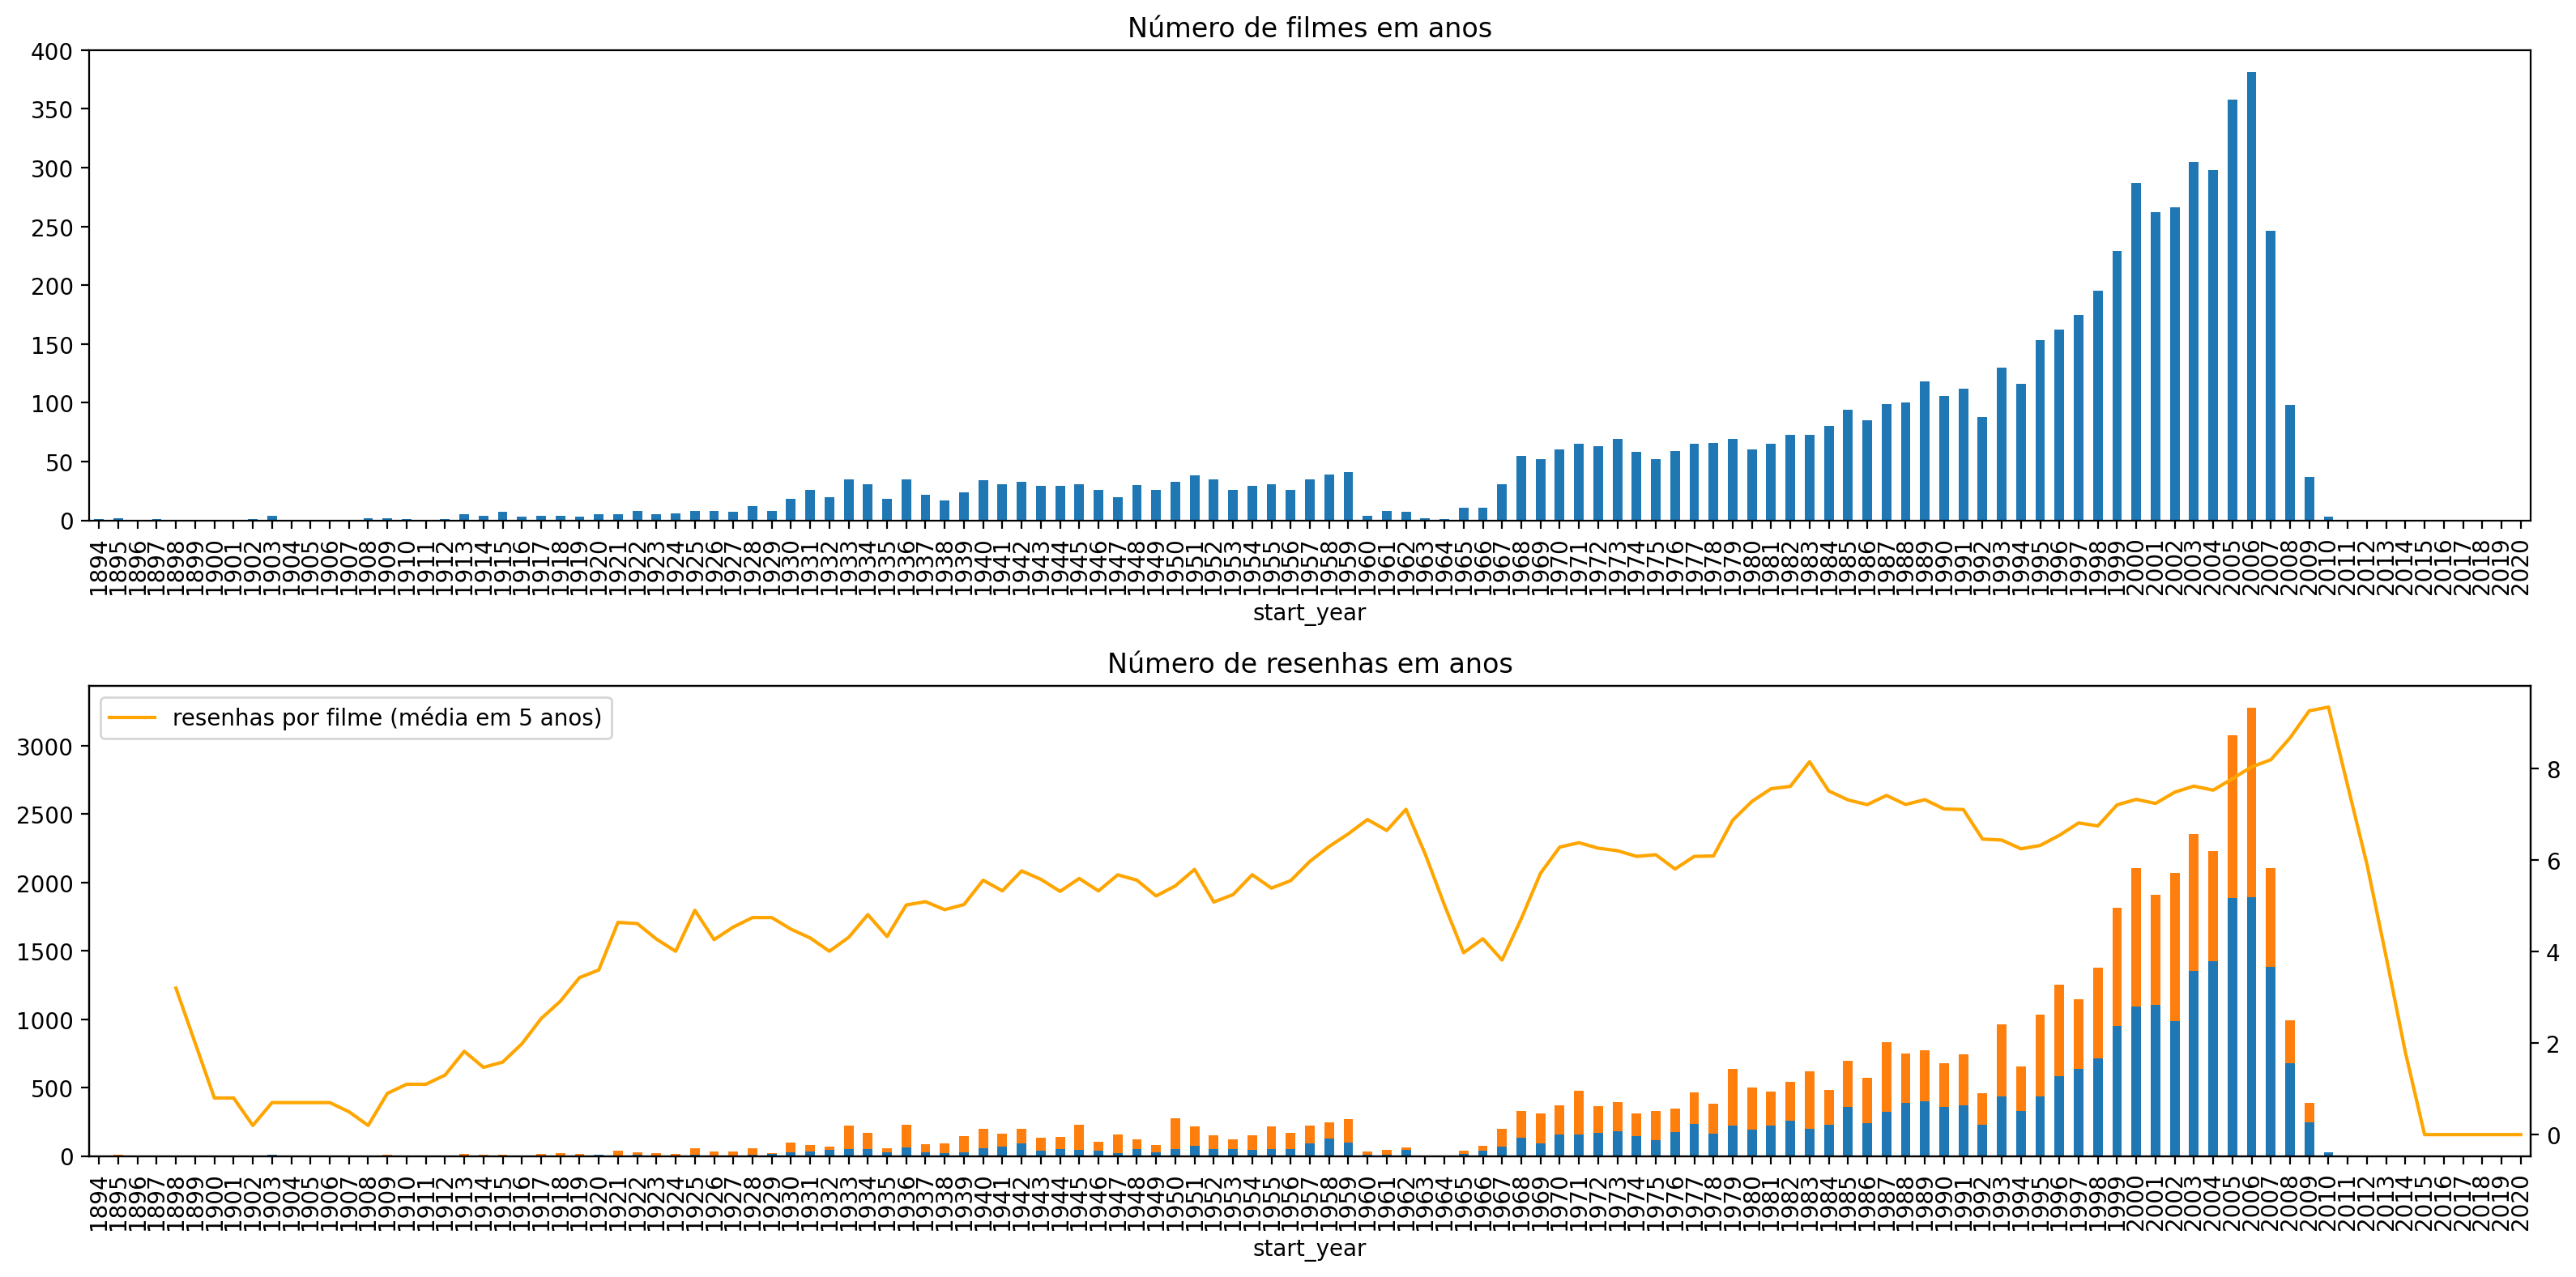

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

### Verifica-se, pela análise dos dois gráficos acima, que o número de resenhas sofreu um grande aumentos nos anos mais recentes, o que pode se dar pela disseminação do uso da internet e redes sociais. O acesso a essas ferramentas possibilitou a mais pessoas pulicarem suas resenhas e se fazerem lidos.


Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

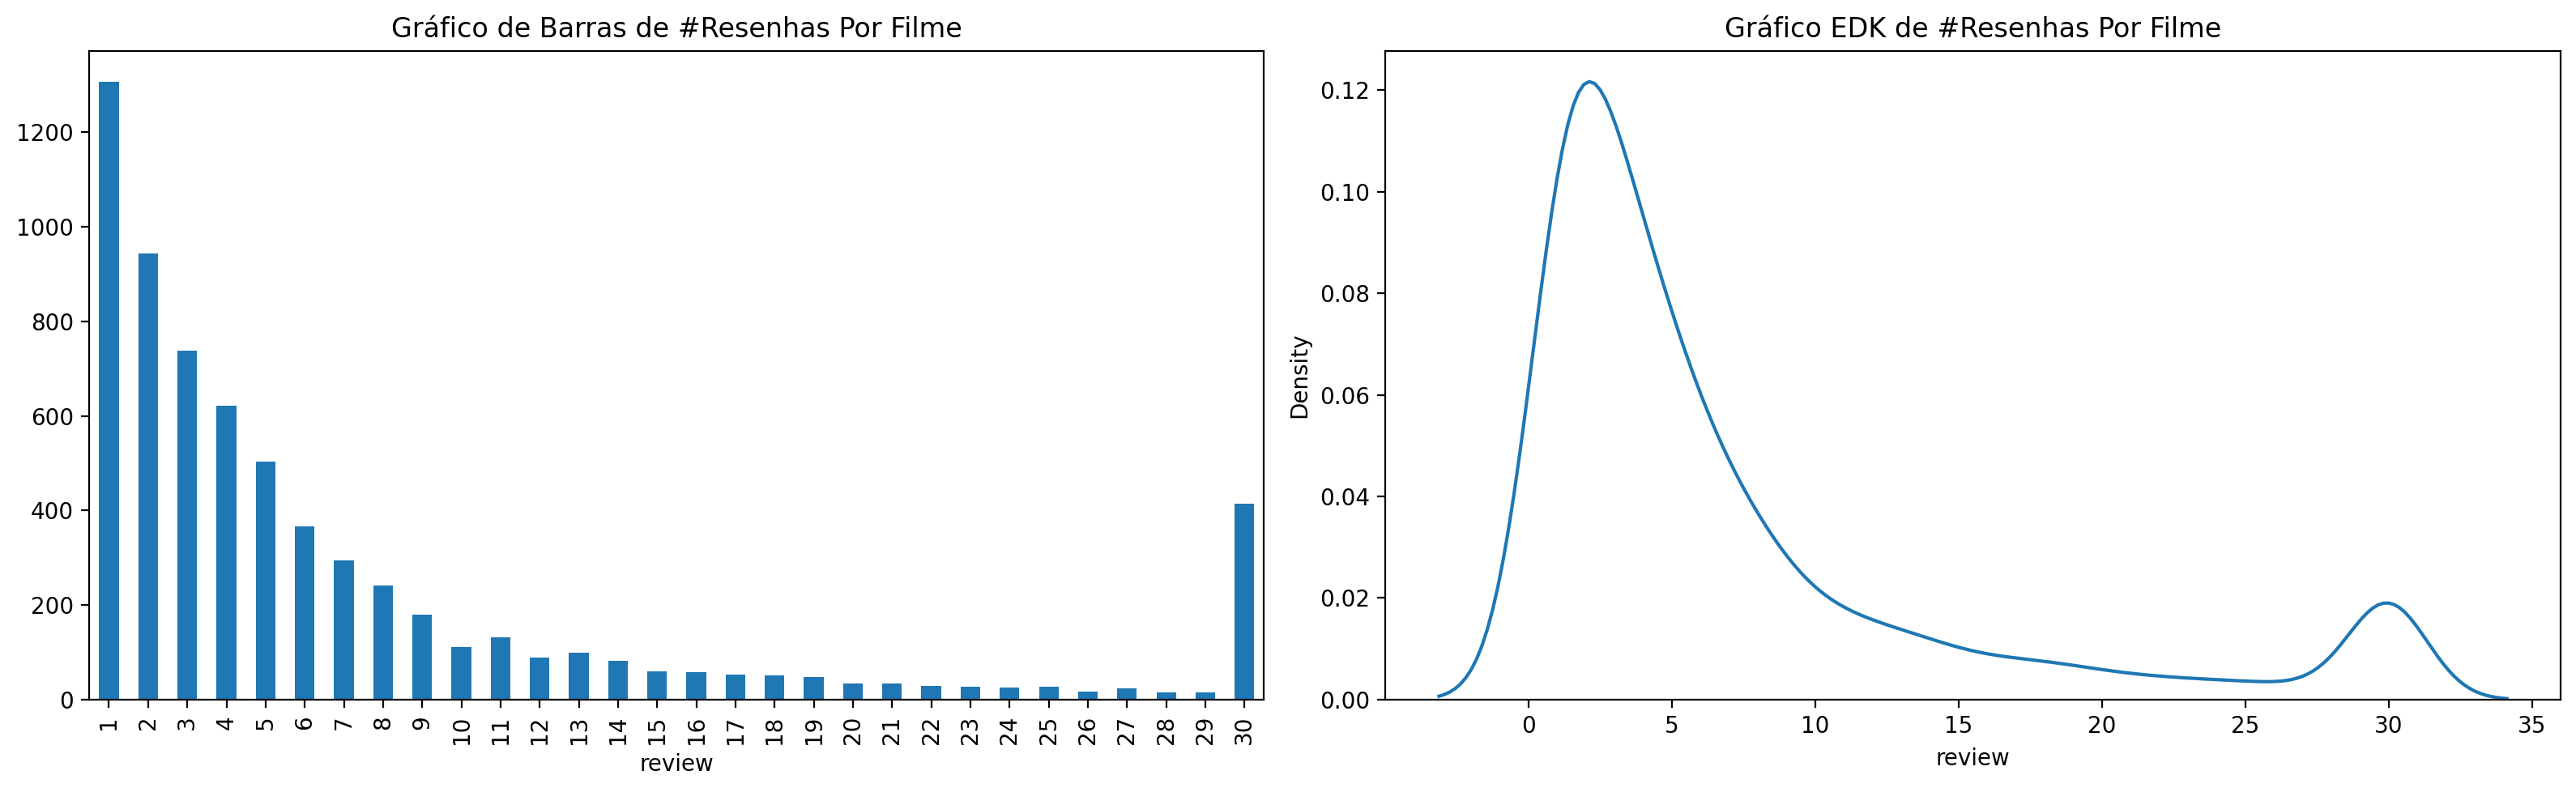

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

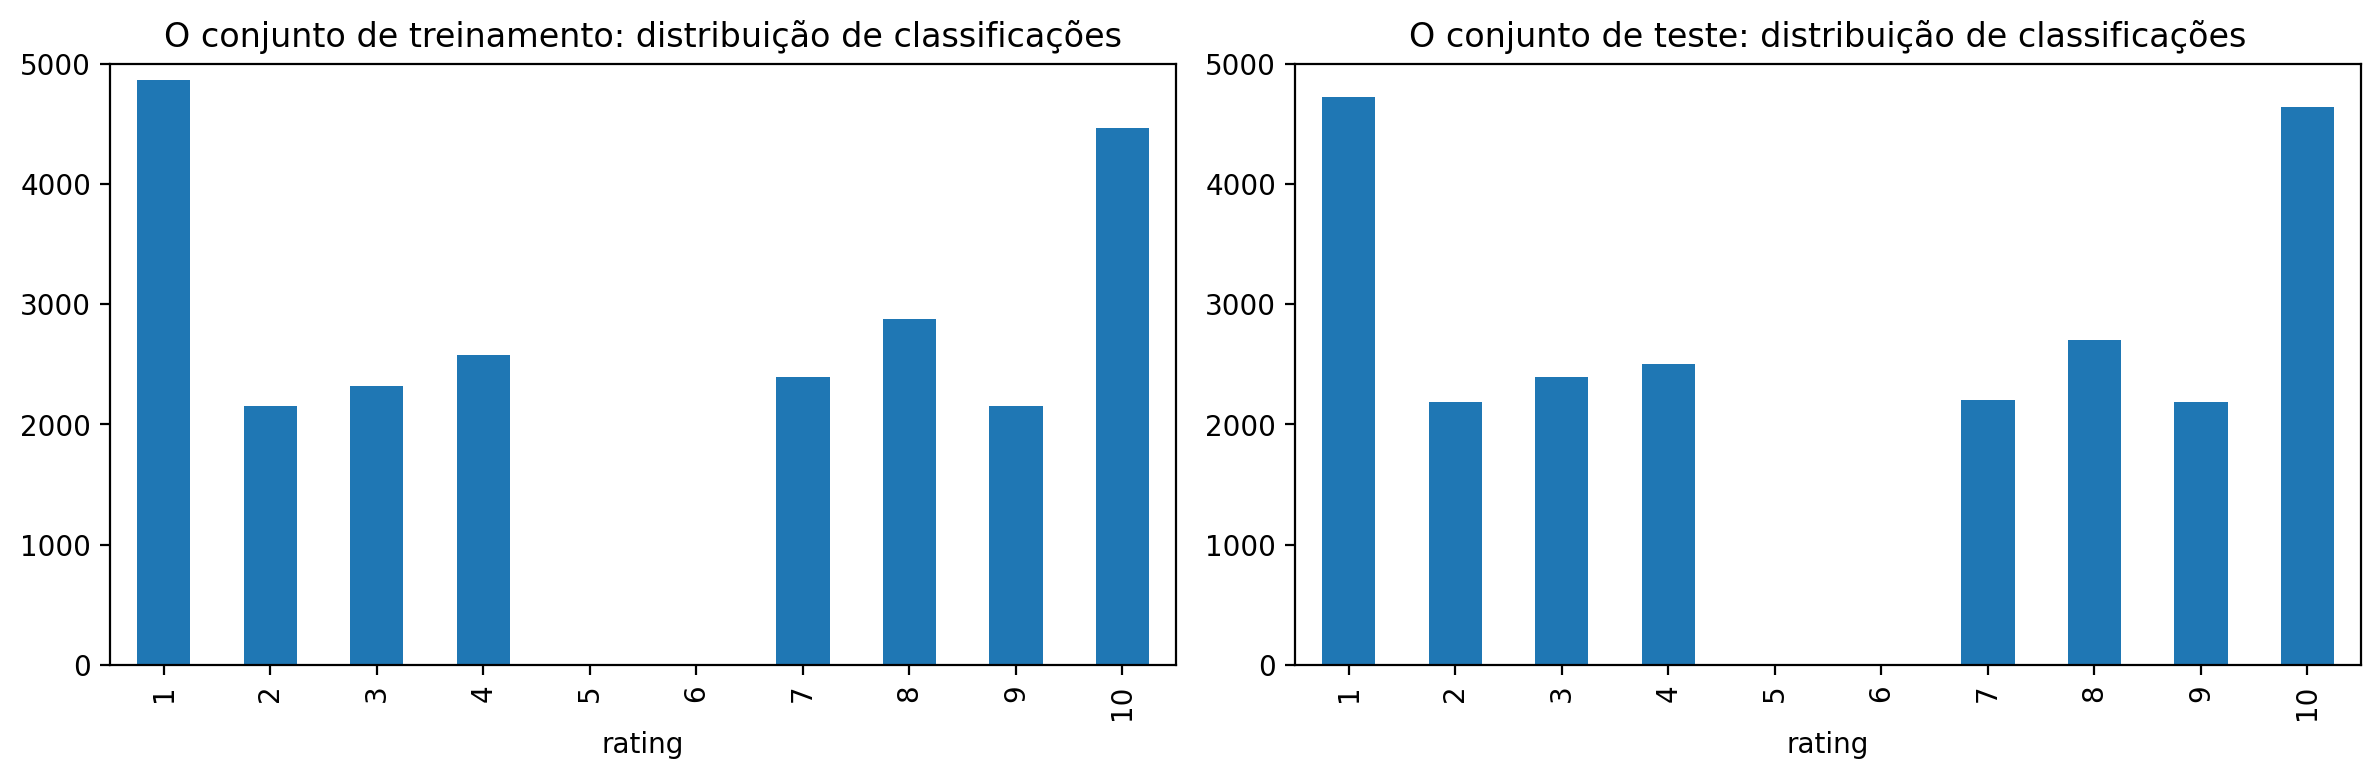

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

<ipython-input-21-5f5d85b65872>:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-21-5f5d85b65872>:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
<ipython-input-21-5f5d85b65872>:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-21-5f5d85b65872>:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

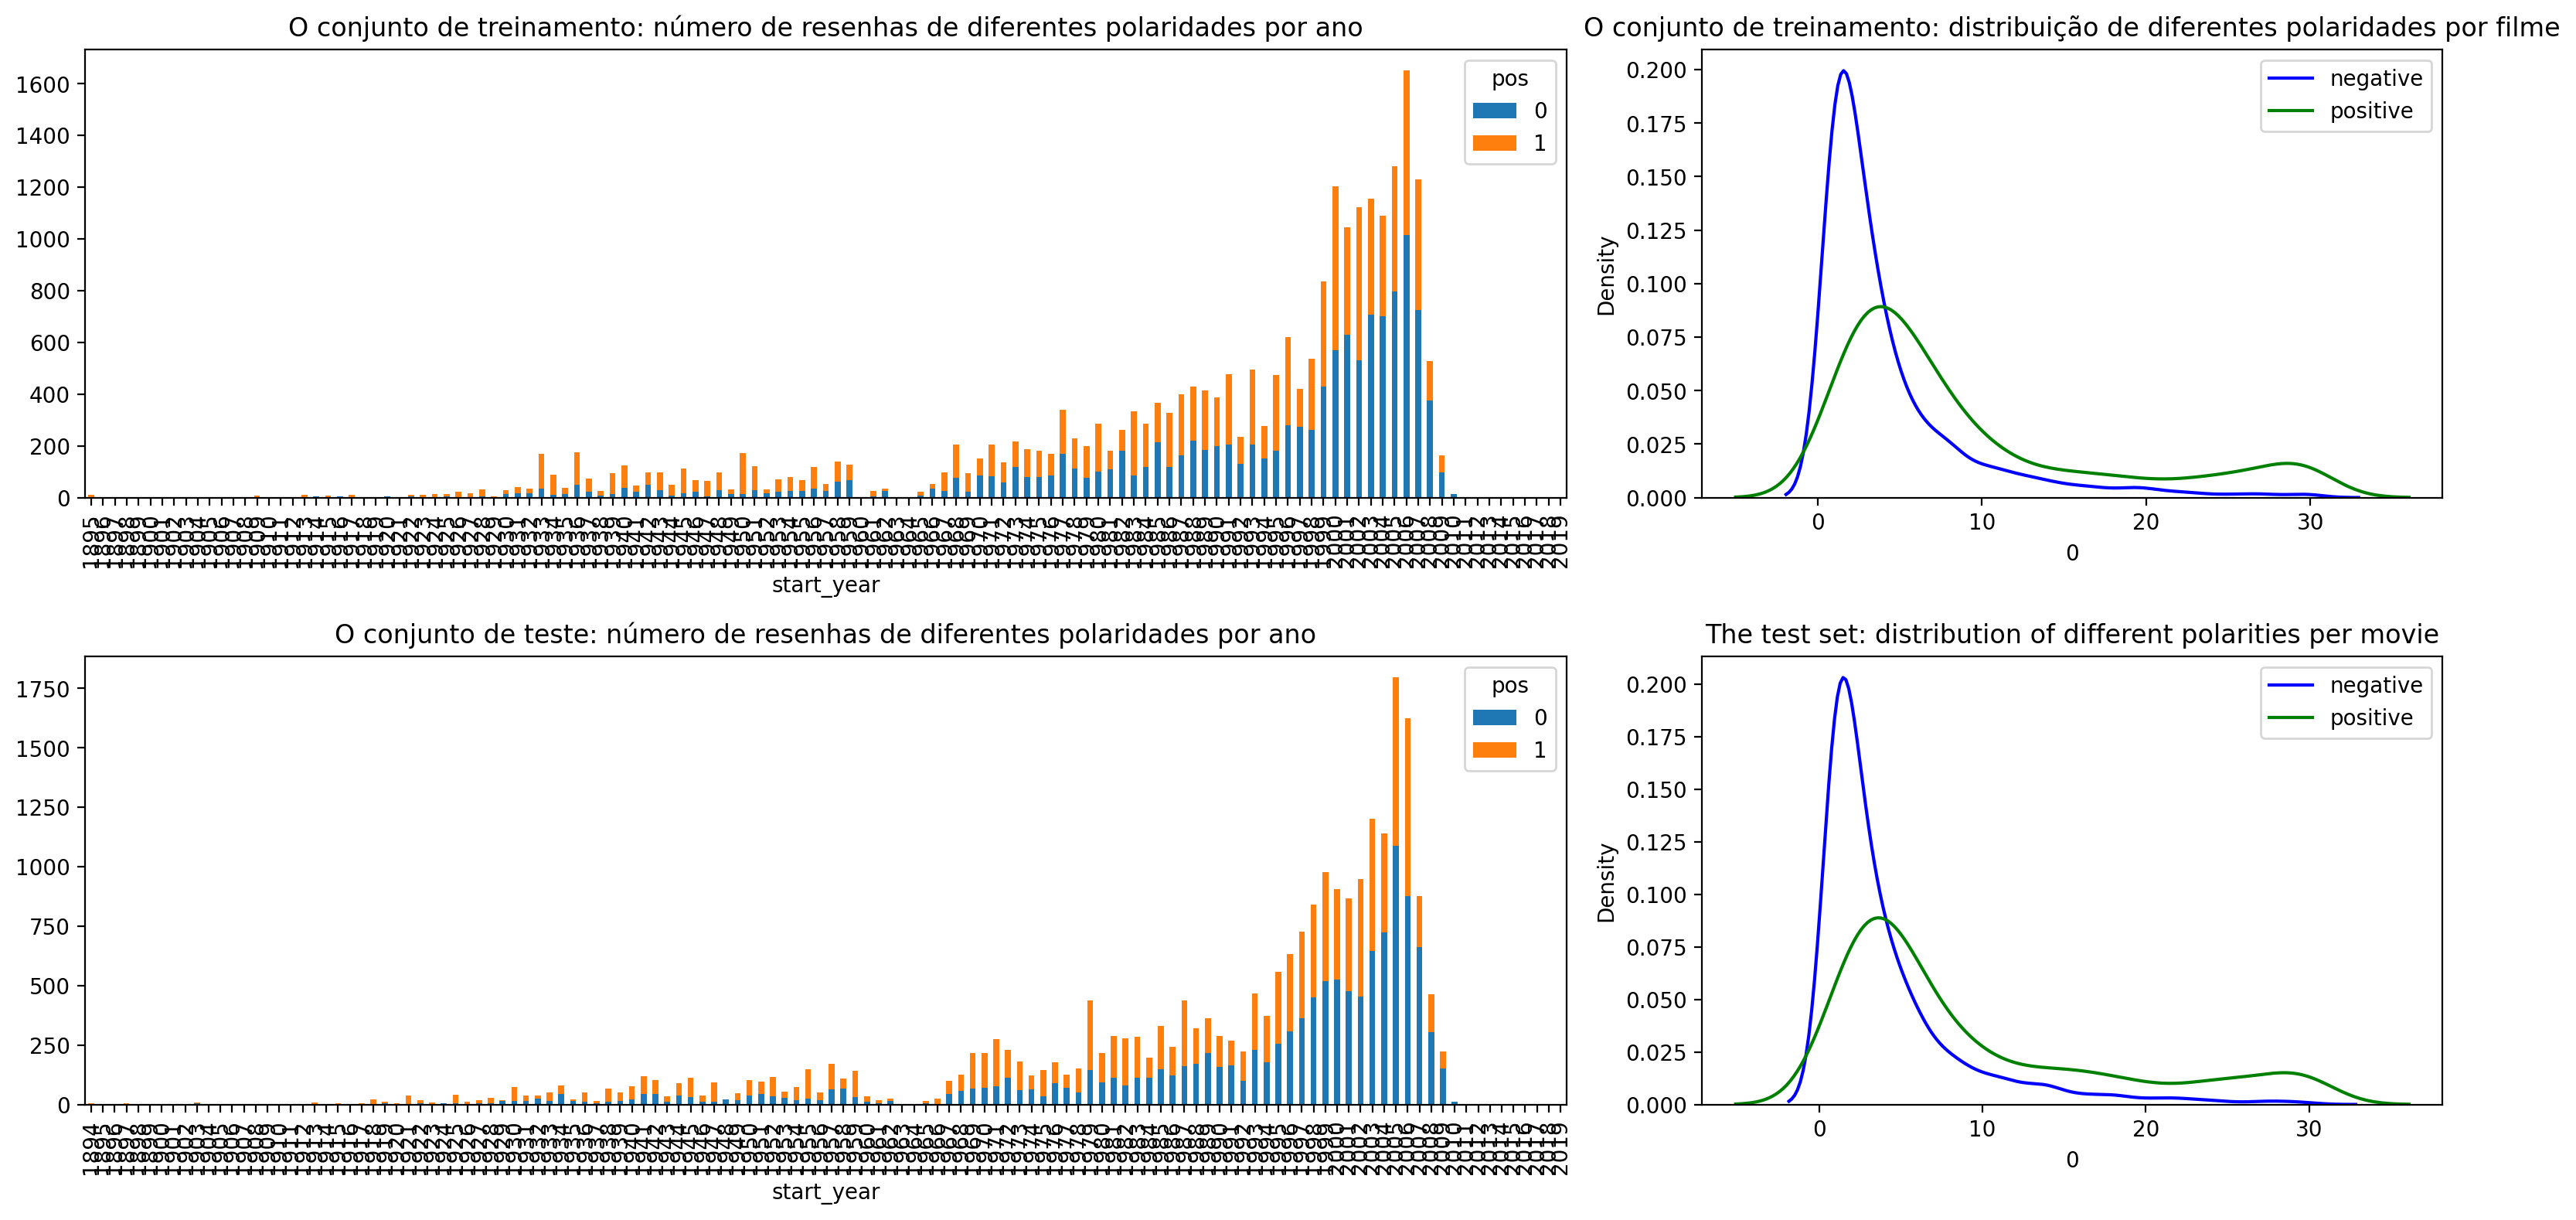

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

### Os gráficos mostram que os conjuntos de treinamento e teste possuem uma distribuição parecida, mostrando a consistência dos dados.


## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [22]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for data_type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[data_type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # Armazenar o F1 Score máximo e o threshold correspondente
        max_f1_score_idx = np.argmax(f1_scores)
        eval_stats[data_type]['F1 Score'] = f1_scores[max_f1_score_idx]

        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[data_type]['APS'] = aps

        color = 'blue' if data_type == 'train' else 'green'

        # Plotar F1 Score
        ax = axs[0]
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max F1={f1_scores[max_f1_score_idx]:.2f} @ threshold={f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score vs Threshold')

        # Plotar ROC Curve
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')

        # Plotar Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Accuracy', 'F1 Score', 'APS', 'ROC AUC'])

    print(df_eval_stats)

    plt.tight_layout()
    plt.show()

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [24]:
def normalize_text_for_sentiment(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\']', ' ', text)

    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()

    stop_words = set(nltk_stopwords.words('english'))

    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    normalized_text = ' '.join(tokens)

    return normalized_text

In [25]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text_for_sentiment)

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [26]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [27]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [28]:
count_vectorizer = CountVectorizer(stop_words='english')
X_train_bow = count_vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_bow = count_vectorizer.transform(df_reviews_test['review_norm'])

In [29]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_tfidf = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

In [30]:
dummy_clf.fit(X_train_tfidf, train_target)
dummy_pred = dummy_clf.predict(X_test_tfidf)

0.5015510134704457
0.0
          train  test
Accuracy   0.50  0.50
F1 Score   0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


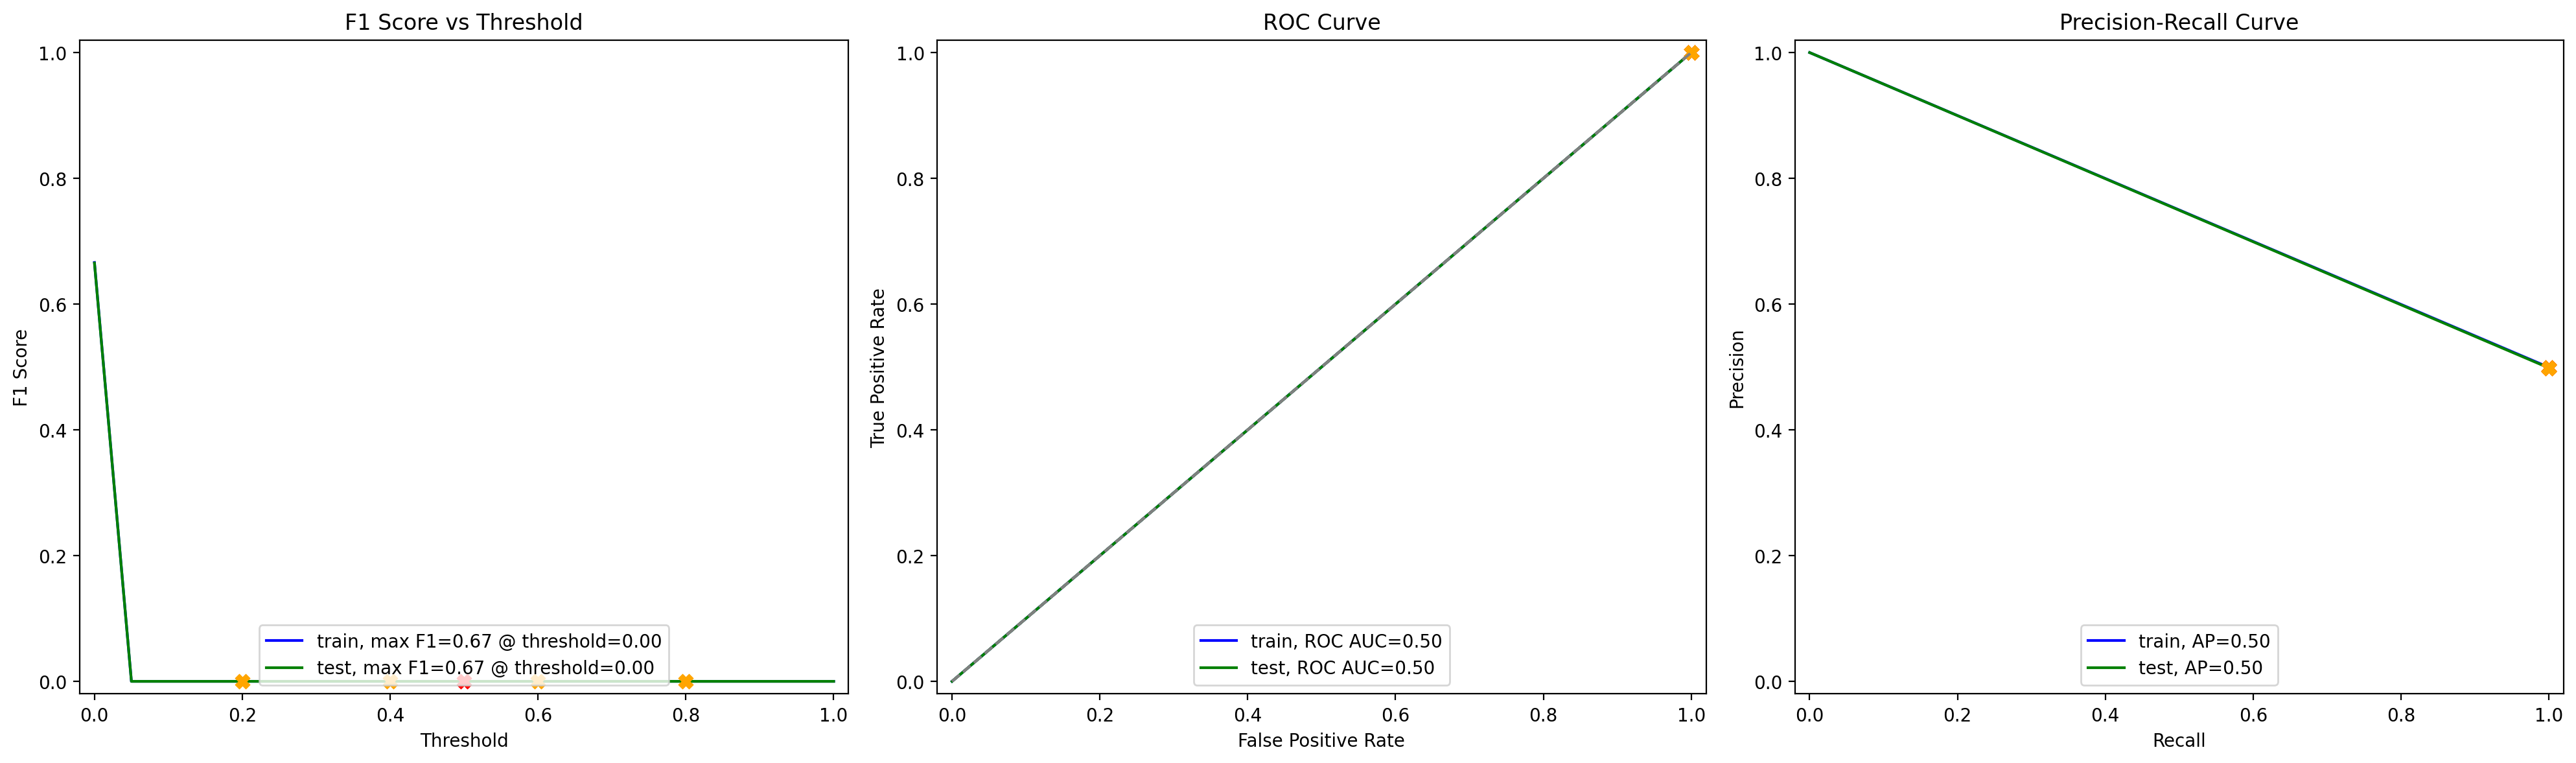

In [31]:
print(accuracy_score(test_target, dummy_pred))
print(f1_score(test_target, dummy_pred))
evaluate_model(dummy_clf, X_train_tfidf, train_target, X_test_tfidf, test_target)

# Acurácia e F1 calculadas.

### Modelo 1 - NLTK, TF-IDF e Regressão Linear

TF-IDF

In [32]:
train_corpus = df_reviews_train['review_norm']
target_train = df_reviews_train['pos']


test_corpus = df_reviews_test['review_norm']

count_tf_idf = TfidfVectorizer(stop_words='english')

tf_idf = count_tf_idf.fit_transform(train_corpus)

features_train = tf_idf
target_train = df_reviews_train['pos']

features_test = count_tf_idf.transform(test_corpus)

In [33]:
lr = LinearRegression()
lr.fit(features_train, target_train)
pred_test = lr.predict(features_test)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

            pos
0      0.526273
1      0.556628
2      0.908450
3      0.792942
4      1.750354
...         ...
23528  1.196501
23529  0.169949
23530  0.321063
23531  0.872877
23532  1.360006

[23533 rows x 1 columns]


In [34]:
# evaluate_model(lr, features_train, target_train, features_test, test_target)

# Nesse caso, por ser regressão linear, a função dá erro.

### Modelo 2 - NLTK, TF-IDF e Regressão Logística


In [35]:
log = LogisticRegression()
log.fit(features_train, target_train)
pred_test = log.predict(features_test)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

       pos
0        0
1        1
2        1
3        1
4        1
...    ...
23528    1
23529    0
23530    1
23531    1
23532    1

[23533 rows x 1 columns]


          train  test
Accuracy   0.93  0.88
F1 Score   0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


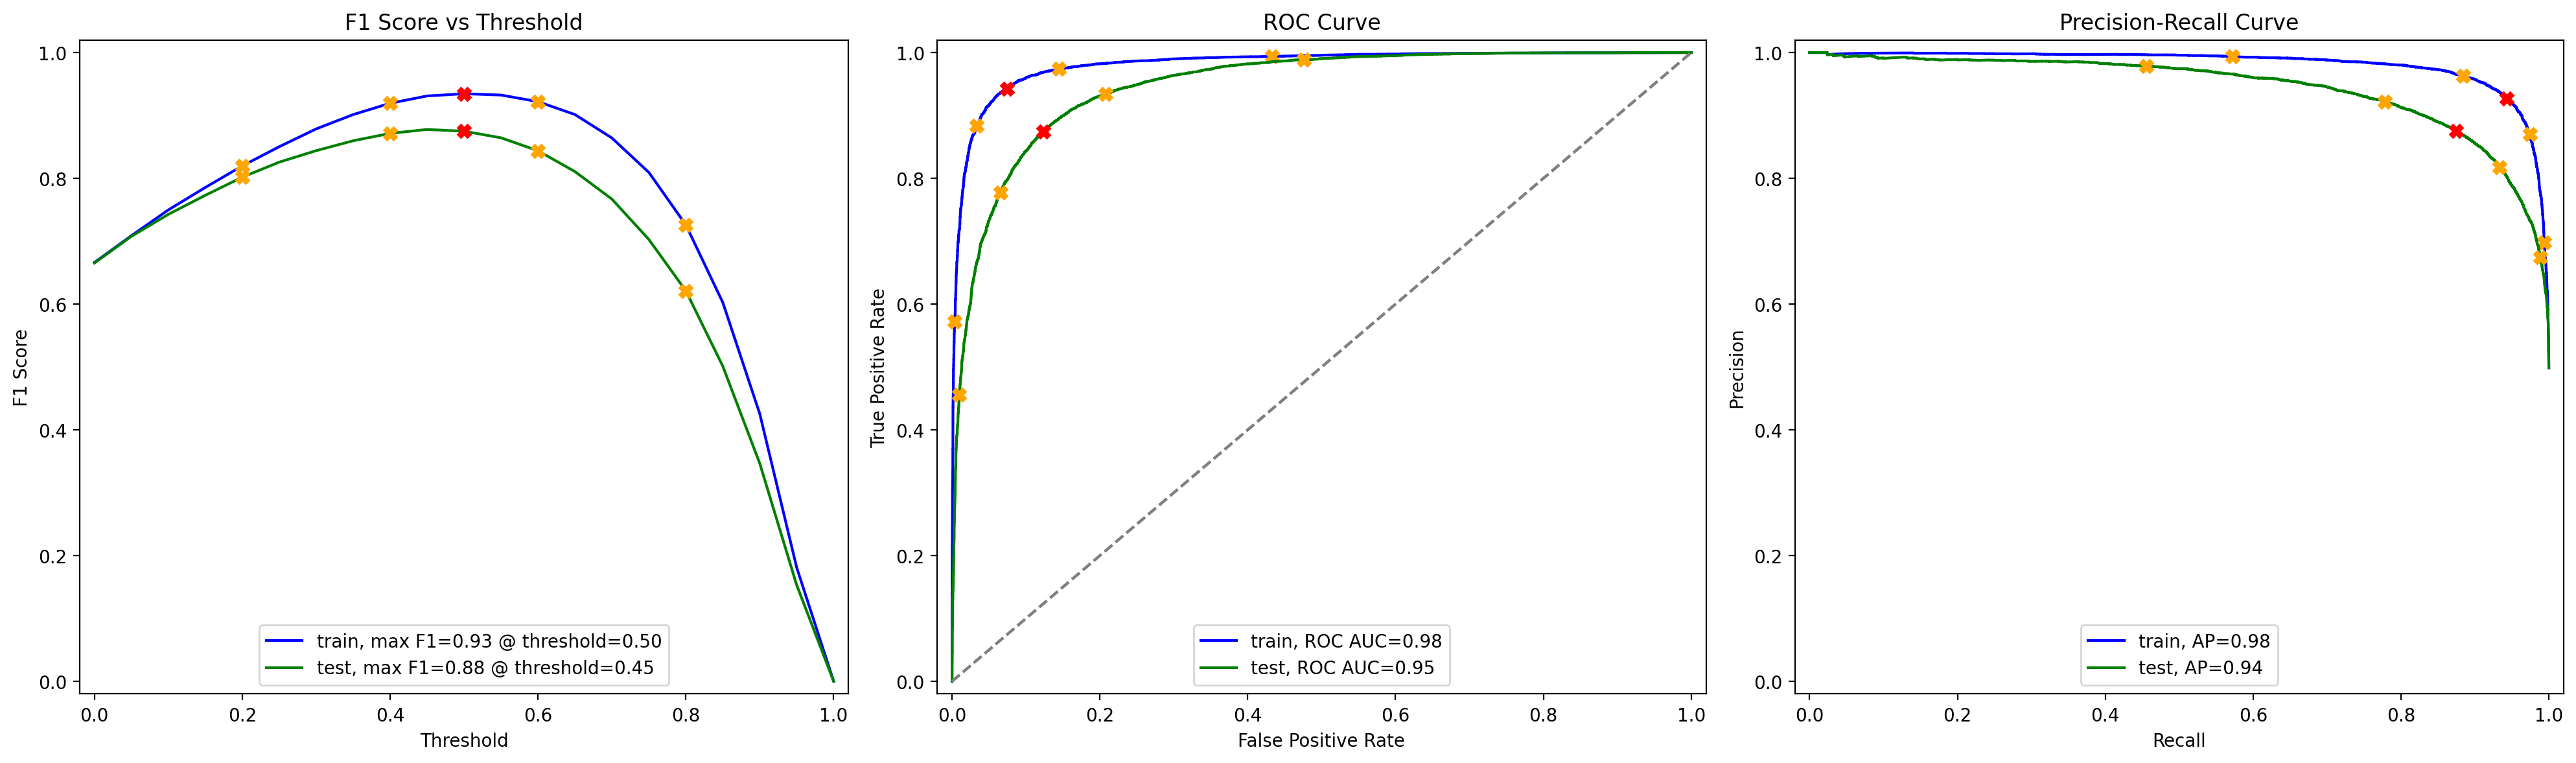

In [36]:
evaluate_model(log, features_train, target_train, features_test, test_target)

### Modelo 3 - spaCy, TF-IDF e Regressão Linear

In [37]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def text_preprocessing_3(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [39]:
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-Z\']', ' ', text)
    clean_text = ' '.join(clean_text.split())

    return clean_text

In [40]:
df_reviews_m3 = df_reviews.copy()
df_reviews_m3['review_norm'] = df_reviews_m3['review'].apply(clear_text)

In [41]:
df_reviews_m3 = df_reviews.copy()
df_reviews_m3['review_norm'] = df_reviews_m3['review'].apply(clear_text)

In [42]:
df_reviews_m3_train = df_reviews_m3.query('ds_part == "train"').copy()
df_reviews_m3_test = df_reviews_m3.query('ds_part == "test"').copy()

train_target = df_reviews_m3_train['pos']
test_target = df_reviews_m3_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [43]:
train_data3 = df_reviews_m3_train
test_data3 = df_reviews_m3_test

train_corpus3 = df_reviews_m3_train['review_norm']
stop_words = list(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit_transform(train_corpus3)

features_train3 = tf_idf
target_train3 = train_data3.pos

test_corpus3 = df_reviews_m3_test['review_norm']
features_test3 = count_tf_idf.transform(test_corpus3)


In [44]:
lr = LinearRegression()
lr.fit(features_train3, target_train3)
pred_test = lr.predict(features_test3)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

            pos
0      0.415695
1      0.611243
2      0.961422
3      0.635934
4      1.195714
...         ...
23528  1.731387
23529 -0.240807
23530  0.437460
23531  1.451789
23532  1.155970

[23533 rows x 1 columns]


In [45]:
# evaluate_model(lr, features_train3, target_train3, features_test3, test_target)

### Modelo 4 - spaCy, TF-IDF e Regressão Logística

In [46]:
log_3 = LogisticRegression()
log_3.fit(features_train3, target_train3)
pred_test = log_3.predict(features_test3)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

       pos
0        0
1        1
2        1
3        1
4        1
...    ...
23528    1
23529    0
23530    1
23531    1
23532    1

[23533 rows x 1 columns]


          train  test
Accuracy   0.94  0.88
F1 Score   0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


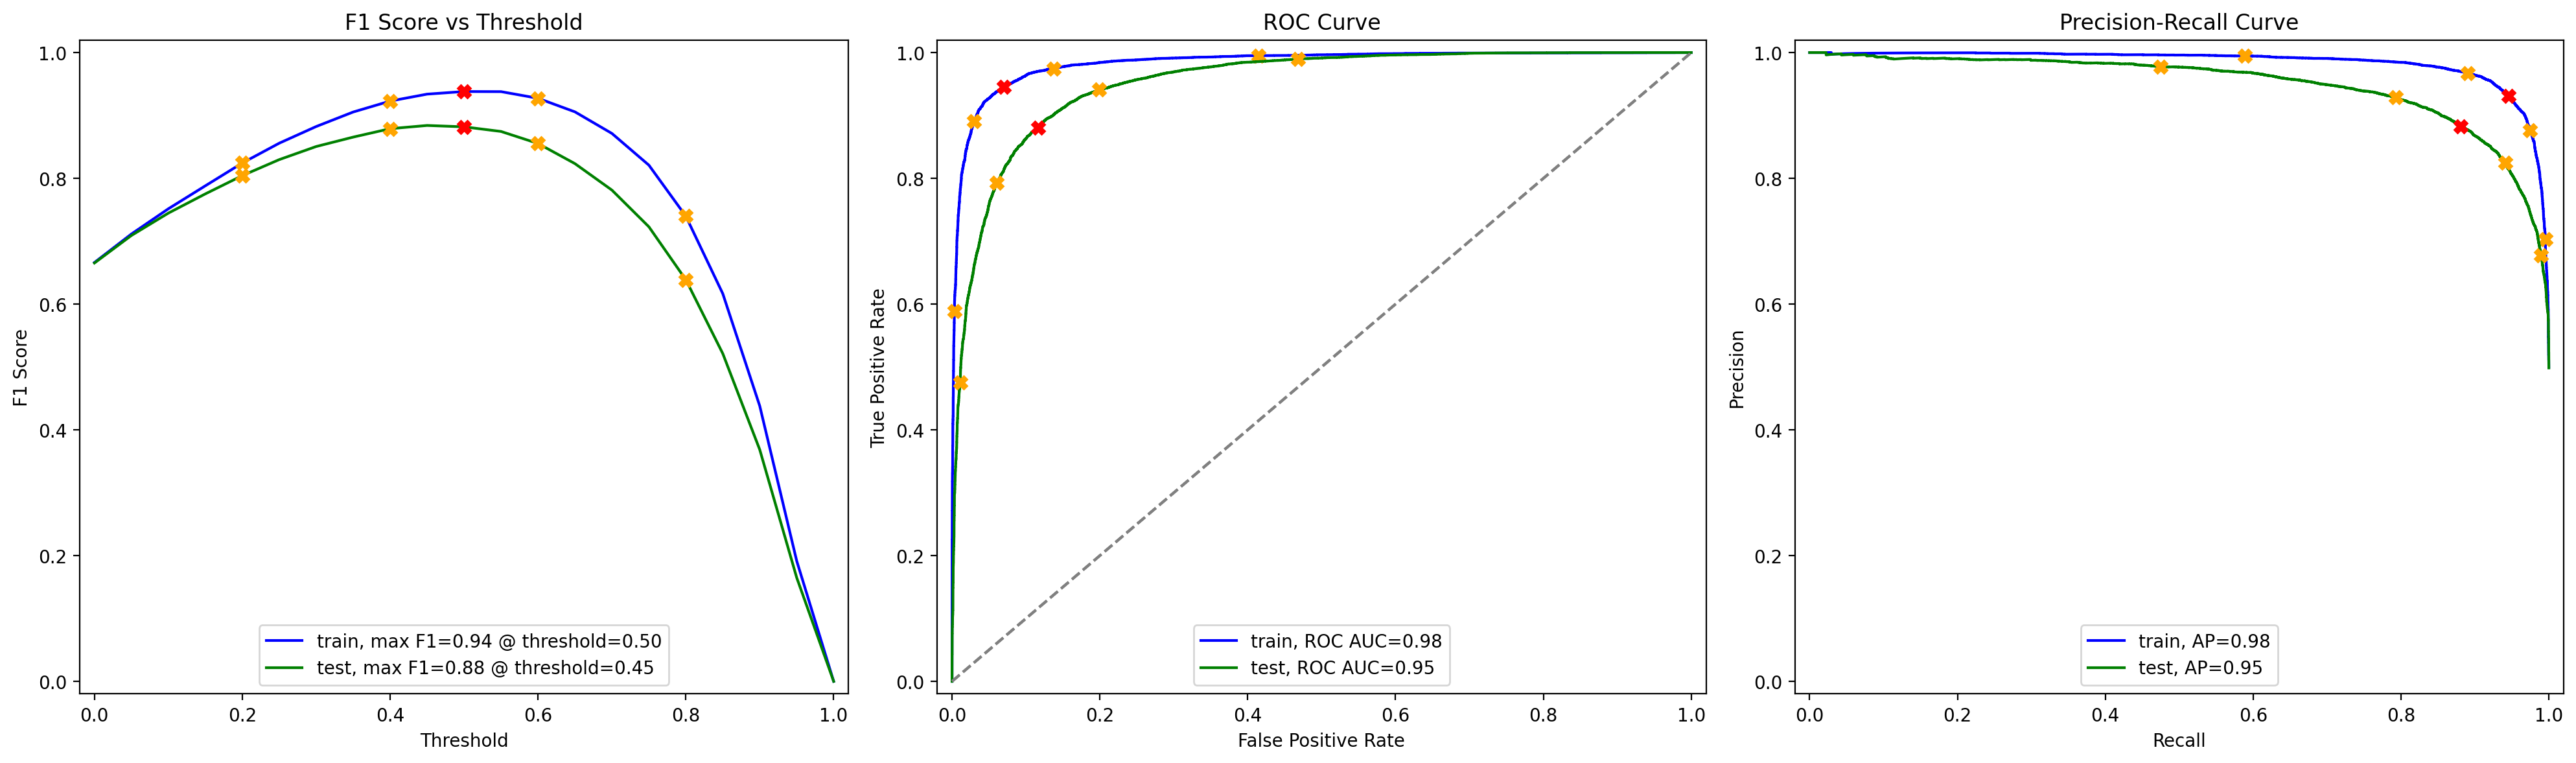

In [47]:
evaluate_model(log_3, features_train3, target_train3, features_test3, test_target)

### Modelo 5 - SpaCy, TF-IDF e LGBMClassifier

In [48]:
from lightgbm import LGBMClassifier

In [49]:
lgbm = LGBMClassifier()
lgbm.fit(features_train, target_train)
pred_test = lgbm.predict(features_test)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.971377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458482
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 10238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


       pos
0        0
1        1
2        0
3        1
4        1
...    ...
23528    1
23529    0
23530    1
23531    1
23532    1

[23533 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


          train  test
Accuracy   0.91  0.85
F1 Score   0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


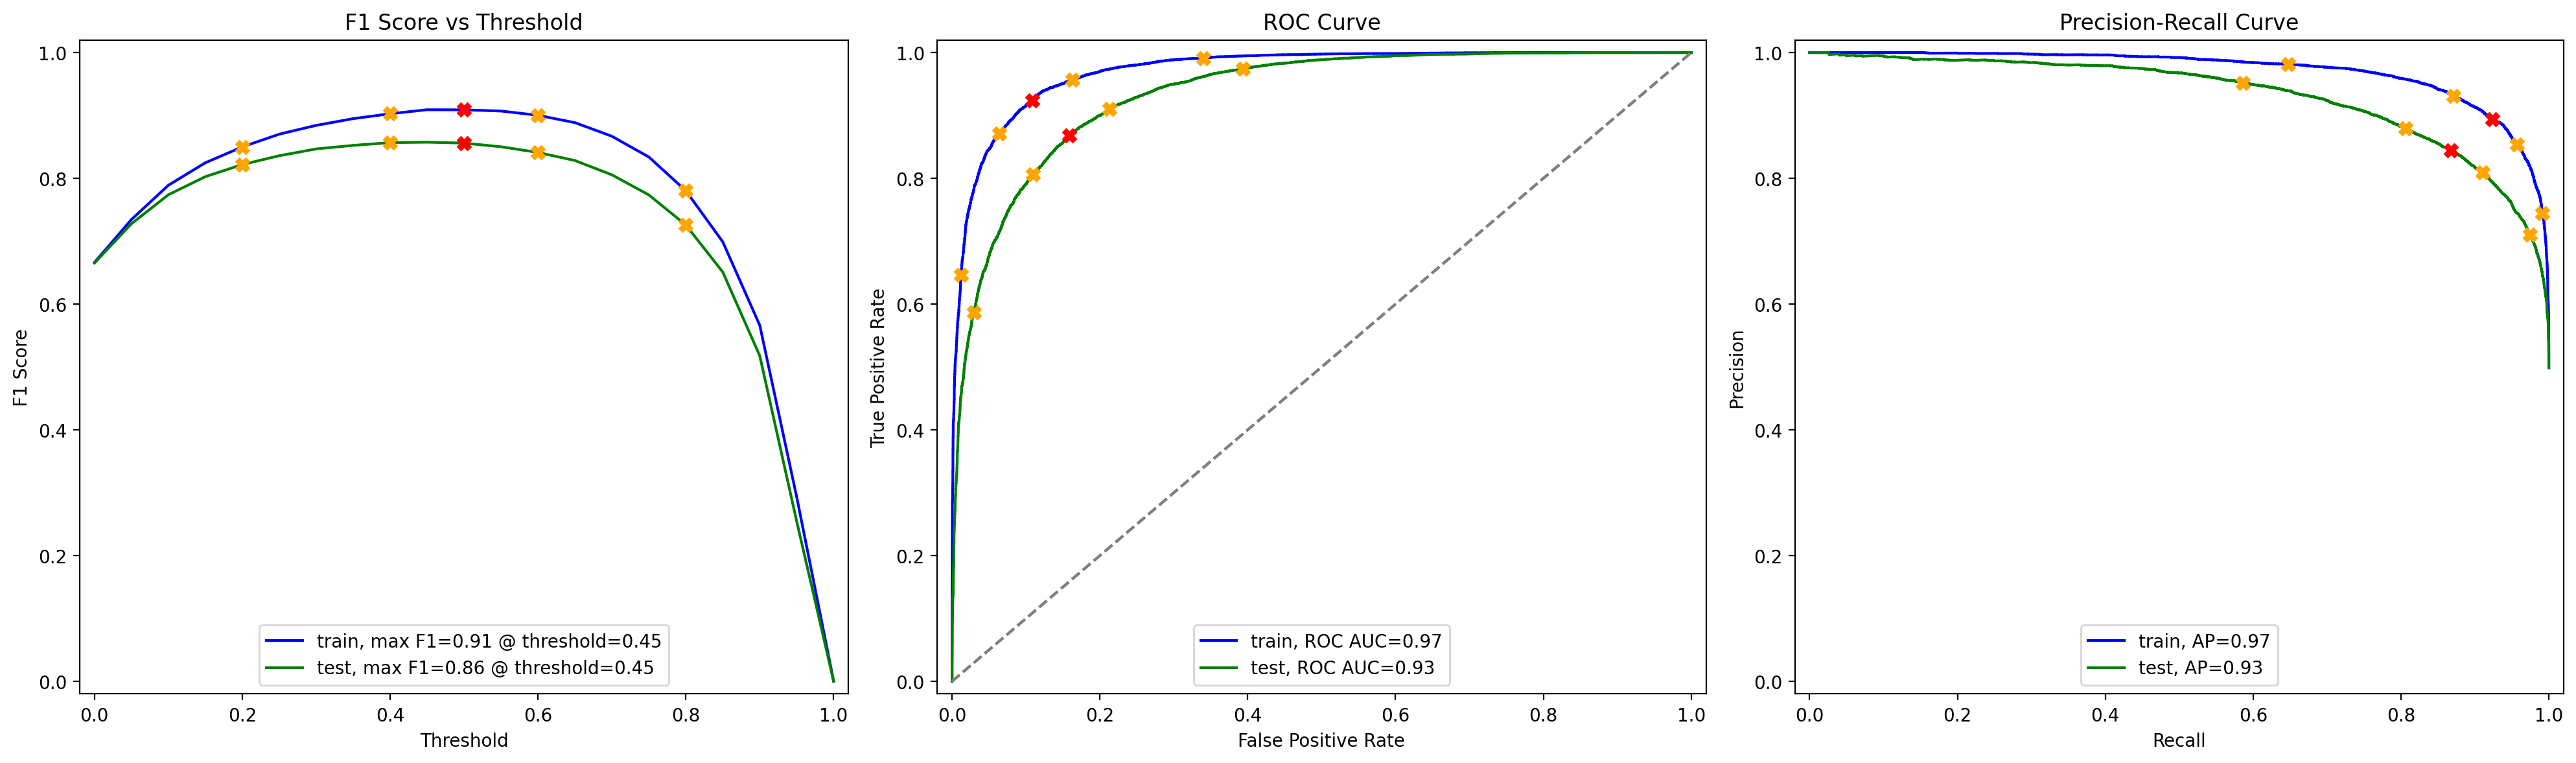

In [50]:
evaluate_model(lgbm, features_train, train_target, features_test, test_target)

###  Modelo 6 - BERT

In [51]:
import torch
import transformers
from transformers import BertTokenizer

In [52]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [53]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')

    ids_list = []
    attention_mask_list = []

    # texto para IDs de tokens preenchidos com suas máscaras de atenção

    for input_text in tqdm(texts, disable=disable_progress_bar):
      ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
      padded = np.array(ids + [0]*(max_length - len(ids)))
      attention_mask = np.where(padded != 0, 1, 0)
      ids_list.append(padded)
      attention_mask_list.append(attention_mask)


    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo {device}.')


    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [54]:
# Atenção! A execução do BERT pode levar muito tempo na CPU. Se você tiver uma GPU, use-a.
train_features_6 = BERT_text_to_embeddings(df_reviews['review_norm'], force_device='cuda')
target = df_reviews['pos']

  0%|          | 0/47329 [00:00<?, ?it/s]

Usando o dispositivo cuda.


  0%|          | 0/474 [00:00<?, ?it/s]

<ipython-input-53-3b53fdf98399>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [55]:
train_features_bert, test_features_bert, train_target_bert, test_target_bert = train_test_split(train_features_6, target, test_size=0.2, random_state=42)

In [56]:
print(df_reviews_train['review_norm'].shape)
print(train_features_6.shape)
print(train_target.shape)

(23796,)
(47329, 768)
(23796,)


In [57]:
# se você tiver as incorporações, é aconselhável salvá-las para tê-las prontas
np.savez_compressed('features_6.npz', train_features_6=train_features_6, test_features_6=test_features_bert)

# e carregar...
with np.load('features_6.npz') as data:
    train_features_6 = data['train_features_6']
    test_features_6 = data['test_features_6']

## Minhas Resenhas

In [58]:
my_reviews = pd.DataFrame([
    "A heartwarming tale that hits all the right emotional notes without feeling forced.",
    "This film is a visual masterpiece, but the plot left much to be desired.",
    "A laugh-out-loud comedy that’s perfect for a weekend escape.",
    "While the action scenes are thrilling, the storyline feels a bit too predictable.",
    "An intense thriller that will keep you on the edge of your seat until the very end.",
    "Great performances, but the pacing made it drag in parts.",
    "A gripping story of survival, but the emotional depth wasn't fully explored.",
    "The chemistry between the leads makes this rom-com a joy to watch.",
    "Visually stunning, but the lack of character development holds it back.",
    "An ambitious film that delivers on style but falters in substance."

], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text_for_sentiment)

my_reviews

,review,review_norm
0,A heartwarming tale that hits all the right em...,heartwarming tale hit right emotional note wit...
1,"This film is a visual masterpiece, but the plo...",film visual masterpiece plot left much desired
2,A laugh-out-loud comedy that’s perfect for a w...,laugh loud comedy perfect weekend escape
3,"While the action scenes are thrilling, the sto...",action scene thrilling storyline feel bit pred...
4,An intense thriller that will keep you on the ...,intense thriller keep edge seat end
5,"Great performances, but the pacing made it dra...",great performance pacing made drag part
6,"A gripping story of survival, but the emotiona...",gripping story survival emotional depth n't fu...
7,The chemistry between the leads makes this rom...,chemistry lead make rom com joy watch
8,"Visually stunning, but the lack of character d...",visually stunning lack character development h...
9,An ambitious film that delivers on style but f...,ambitious film delivers style falter substance


### Modelo 2

In [59]:

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text_for_sentiment)

train_texts = [
    "A heartwarming tale that hits all the right emotional notes.",
    "A visual masterpiece with a compelling plot.",
    "A comedy perfect for a weekend escape.",
    "An action-packed thriller with unexpected twists."
]
train_labels = [1, 1, 1, 0]


stop_words = list(nltk.corpus.stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

tf_idf_train = count_tf_idf.fit_transform(train_texts)

log = LogisticRegression()
log.fit(tf_idf_train, train_labels)

texts = my_reviews['review_norm']

texts_transformed = count_tf_idf.transform(texts)

my_reviews_pred_prob = log.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.79:  heartwarming tale hit right emotional note without feeling forced
0.79:  film visual masterpiece plot left much desired
0.79:  laugh loud comedy perfect weekend escape
0.70:  action scene thrilling storyline feel bit predictable
0.70:  intense thriller keep edge seat end
0.76:  great performance pacing made drag part
0.77:  gripping story survival emotional depth n't fully explored
0.76:  chemistry lead make rom com joy watch
0.76:  visually stunning lack character development hold back
0.76:  ambitious film delivers style falter substance


### Modelo 3

### Modelo 4

In [60]:
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text_for_sentiment)


train_texts = [
    "A heartwarming tale that hits all the right emotional notes.",
    "A visual masterpiece with a compelling plot.",
    "A comedy perfect for a weekend escape.",
    "An action-packed thriller with unexpected twists."
]
train_labels = [1, 1, 1, 0]

stop_words = list(nltk.corpus.stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

tf_idf_train = tfidf_vectorizer_3.fit_transform(train_texts)

model_4 = LogisticRegression()
model_4.fit(tf_idf_train, train_labels)

texts = my_reviews['review_norm']

texts_transformed = tfidf_vectorizer_3.transform(texts.apply(lambda x: x))


my_reviews_pred_prob = model_4.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.79:  heartwarming tale hit right emotional note without feeling forced
0.79:  film visual masterpiece plot left much desired
0.79:  laugh loud comedy perfect weekend escape
0.70:  action scene thrilling storyline feel bit predictable
0.70:  intense thriller keep edge seat end
0.76:  great performance pacing made drag part
0.77:  gripping story survival emotional depth n't fully explored
0.76:  chemistry lead make rom com joy watch
0.76:  visually stunning lack character development hold back
0.76:  ambitious film delivers style falter substance


### Modelo 6 - BERT


In [61]:
def BERT_text_to_embeddings(text_series, batch_size=32, force_device=None):


    all_embeddings = []

    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')


    for i in range(0, len(text_series), batch_size):
        batch_text = text_series[i : i + batch_size]

        encoded_input = tokenizer(batch_text.tolist(), padding=True, truncation=True, return_tensors='pt')

        if force_device:
            if force_device == 'cpu':
                device = torch.device('cpu')
            elif force_device == 'cuda':
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            encoded_input = encoded_input.to(device)
            model = model.to(device)


        with torch.no_grad():
            outputs = model(**encoded_input)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        all_embeddings.append(batch_embeddings)
    return np.concatenate(all_embeddings, axis=0)

texts = my_reviews['review_norm']

my_reviews_features_6 = BERT_text_to_embeddings(texts)

classifier = LogisticRegression()
classifier.fit(my_reviews_features_6, my_reviews['review'])

my_reviews_pred_prob = classifier.predict_proba(my_reviews_features_6)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.83:  heartwarming tale hit right emotional note without feeling forced
0.02:  film visual masterpiece plot left much desired
0.02:  laugh loud comedy perfect weekend escape
0.01:  action scene thrilling storyline feel bit predictable
0.03:  intense thriller keep edge seat end
0.02:  great performance pacing made drag part
0.01:  gripping story survival emotional depth n't fully explored
0.01:  chemistry lead make rom com joy watch
0.01:  visually stunning lack character development hold back
0.04:  ambitious film delivers style falter substance


## Conclusões

A conclusão chegada é de que os resultados dos modelos treinados são bastante semelhantes, atingindo o limiar métrico proposto pelo exercício.
Portanto, o nível de precisão da classificação é bastante satisfatório e confiável.
